In [1]:
%load_ext autoreload

%autoreload 2

import numpy as np
import time
import matplotlib
from matplotlib import pyplot as plt
import os

import sys
# sys.path.append('axionCAMB_and_lin_PS/')
# sys.path.append('cosmology/')
# sys.path.append('axion_functions/')
# sys.path.append('halo_model/')

from axionCAMB_and_lin_PS import axionCAMB_wrapper 
from axionCAMB_and_lin_PS import load_cosmology  
from axionCAMB_and_lin_PS import lin_power_spectrum 
from axionCAMB_and_lin_PS import PS_interpolate 
# import axionCAMB_and_lin_PS.axionCAMB_wrapper 
# import axionCAMB_and_lin_PS.load_cosmology  
# import axionCAMB_and_lin_PS.lin_power_spectrum 
# import axionCAMB_and_lin_PS.PS_interpolate 

from halo_model import HMcode_params
from halo_model import PS_nonlin_cold
from halo_model import PS_nonlin_axion

from axion_functions import axion_params

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
start = time.time()

print('#' * 50)
print('axionHMcode is running')
print('#' * 50)

################################################################################
# Set-up experiment parameters and run axionCAMB
################################################################################
#print('#' * 50)
print('Set-up experiment parameters')
#print('#' * 50)

#IMPORTANT: give the correct path to the intput file which contains all important cosmological parameter
input_file_path = 'input_file.txt'
try:
    f = open(input_file_path)
except IOError:
    print("Input file not accessible, pleas check the file path")
finally:
    f.close()
    
#IMPORTANT:Change here the path to the axionCAMB executable path directory (second path in the function)
# assumes that thee axionCAMB executable is names .camb
axionCAMB_exe_path = '/Users/sophievogt/Documents/axionCAMB'
if os.path.exists(axionCAMB_exe_path+'/./camb') == False:
    print("executabel axionCAMB is not in the given directory, pleas check the path")
      
    
################################################################################    
# save cosmological parameter in a dictionary 
################################################################################
cosmos = load_cosmology.load_cosmology_input(input_file_path) 
cosmos_LCDM = load_cosmology.load_LCDM_cosmology_input(input_file_path)
print("computing the non-linear total matter power spectrum in the folowing MDM colsmology \n")
print("omega_m = {0} \nomega_cdm = {1} \nomega_ax = {2} \nomega_b = {3} \nm_ax = {4}eV \nz = {5} \nh = {6} \n".format(cosmos['omega_m_0'], cosmos['omega_d_0'], cosmos['omega_ax_0'], cosmos['omega_b_0'], 
                                                                                                                          cosmos['m_ax'], cosmos['z'], cosmos['h']))


################################################################################
# Run axionCAMB on mixed and LCDM cosmology 
################################################################################
print('-' * 50)
print("axionCAMB is running. Computes transfer function for cosmology with a axion fraction of {}"
      .format(cosmos['Omega_ax_0']/(cosmos['Omega_ax_0']+cosmos['Omega_d_0'])))
axionCAMB_wrapper.axioncamb_params('paramfiles/paramfile_axionCAMB.txt', 
                                   cosmos, output_root='paramfiles/cosmos', print_info = False)
axionCAMB_wrapper.run_axioncamb('paramfiles/paramfile_axionCAMB.txt', 
                                axionCAMB_exe_path, 
                                cosmos, print_info = False)

print("axionCAMB is running. Computes transfer function for a LCDM cosmology")
axionCAMB_wrapper.axioncamb_params('paramfiles/paramfile_axionCAMB_LCDM.txt', 
                                   cosmos_LCDM, output_root='paramfiles/cosmos_LCDM', print_info = False)
axionCAMB_wrapper.run_axioncamb('paramfiles/paramfile_axionCAMB_LCDM.txt', 
                                axionCAMB_exe_path, 
                                cosmos_LCDM, print_info = False)
print("computation time: {:.0f} s".format(time.time() -start))


################################################################################
# Create linear power spectra from axionCAMB tranfer functions 
################################################################################
#lin PS on given k range
power_spec_dic_ax = lin_power_spectrum.func_power_spec_dic('paramfiles/cosmos_transfer_out.dat', cosmos)
power_spec_dic_LCDM = lin_power_spectrum.func_power_spec_dic('paramfiles/cosmos_LCDM_transfer_out.dat', cosmos_LCDM)
#interpolated lin PS for the correct computations of the variance



################################################################################
# Compute parameter related to axions and HMCode2020
################################################################################
print('-' * 50)
M_arr = np.logspace(cosmos['M_min'], cosmos['M_max'], 100)
print("Calculate axion quantities; cut-off mass, central density scale of axion density profile and axion halo mass.")
axion_param = axion_params.func_axion_param_dic(M_arr, cosmos, power_spec_dic_ax)
print("Create dictionary with parameters of HMCode2020")
hmcode_params = HMcode_params.HMCode_param_dic(cosmos, power_spec_dic_ax['k'], power_spec_dic_ax['power_cold'])
hmcode_params_LCDM = HMcode_params.HMCode_param_dic(cosmos_LCDM, power_spec_dic_LCDM['k'], power_spec_dic_LCDM['power_cold'])
print("computation time upto here: {:.0f} s".format(time.time() -start))








##################################################
axionHMcode is running
##################################################
Set-up experiment parameters
computing the non-linear total matter power spectrum in the folowing MDM colsmology 

omega_m = 0.14237 
omega_cdm = 0.108 
omega_ax = 0.012 
omega_b = 0.02237 
m_ax = 1e-25eV 
z = 0.0 
h = 0.674 

--------------------------------------------------
axionCAMB is running. Computes transfer function for cosmology with a axion fraction of 0.1


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG


axionCAMB is running. Computes transfer function for a LCDM cosmology


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG


computation time: 61 s
--------------------------------------------------
Calculate axion quantities; cut-off mass, central density scale of axion density profile and axion halo mass.
Create dictionary with parameters of HMCode2020
computation time upto here: 186 s


--------------------------------------------------
Caluclate non-linear power spectrum in mixed DM cosmology with the halo model
Caluclate non-linear power spectrum in LCDM cosmology with the halo model
--------------------------------------------------
Save the non-linear power spectra in a file in the folowing order:
k [h/Mpc], non-lin total matter PS with axions [(Mpc/h)^3] and non-lin total matter PS in LCDM [(Mpc/h)^3]
##################################################
axionHMcode is finished, total computation time: 196 s
##################################################


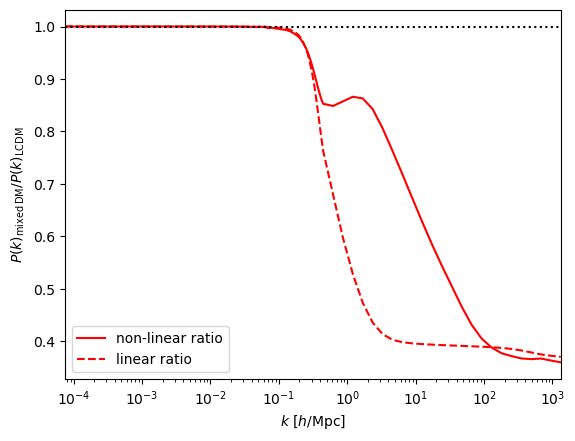

In [3]:

################################################################################
# Caluclate non-linear power spectrum in mixed DM and LCDM cosmology
################################################################################
print('-' * 50)
print('Caluclate non-linear power spectrum in mixed DM cosmology with the halo model')
PS_matter_nonlin = PS_nonlin_axion.func_full_halo_model_ax(M_arr, power_spec_dic_ax, 
                                                              cosmos, hmcode_params, axion_param,
                                                              alpha = False, 
                                                              eta_given = False, 
                                                              one_halo_damping = True, 
                                                              two_halo_damping = False)

print('Caluclate non-linear power spectrum in LCDM cosmology with the halo model')
PS_LCDM_matter_nonlin = PS_nonlin_cold.func_non_lin_PS_matter(M_arr, power_spec_dic_LCDM['k'], power_spec_dic_LCDM['power_total'], 
                                                              cosmos_LCDM, hmcode_params_LCDM, cosmos_LCDM['Omega_m_0'],
                                                              alpha = False, 
                                                              eta_given = False, 
                                                              one_halo_damping = True, 
                                                              two_halo_damping = False)


################################################################################
# Save both power stepctra in files
################################################################################
print('-' * 50)
print("Save the non-linear power spectra in a file in the folowing order:")
print("k [h/Mpc], non-lin total matter PS with axions [(Mpc/h)^3] and non-lin total matter PS in LCDM [(Mpc/h)^3]")
data_ax = np.column_stack([power_spec_dic_ax['k'], PS_matter_nonlin[0], PS_LCDM_matter_nonlin[0]] )
datafile_path = "nonlin_PS_with_axion.txt" #change path if you want
np.savetxt(datafile_path , data_ax)



print('#' * 50)
print("axionHMcode is finished, total computation time: {:.0f} s".format(time.time() -start))
print('#' * 50)


################################################################################
# Make ratio plot of the two power spectra
################################################################################
plt.semilogx(power_spec_dic_ax['k'], PS_matter_nonlin[0]/PS_LCDM_matter_nonlin[0], label='non-linear ratio', color='r')
plt.semilogx(power_spec_dic_ax['k'], power_spec_dic_ax['power_total']/power_spec_dic_LCDM['power_total'], label='linear ratio', linestyle='--', color='r')
plt.axhline(y = 1, linestyle=':', color='black')
plt.margins(x=0)
plt.legend(loc='lower left')
plt.xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
plt.ylabel(r'$P(k)_{\mathrm{mixed\,DM}}/P(k)_{\mathrm{LCDM}}$')
plt.show()


In [4]:
PS_matter_nonlin = PS_nonlin_axion.func_full_halo_model_ax(M_arr, power_spec_dic_ax, 
                                                              cosmos, hmcode_params, axion_param,
                                                              alpha = False, 
                                                              eta_given = False, 
                                                              one_halo_damping = True, 
                                                              two_halo_damping = False
                                                              )